In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
path = "C:\\Users\\JESSE\\Downloads\\1960_onwards.csv"
df = pd.read_csv(path)
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

### Forecasting Models

In [114]:
# Target Variable 
y_gdp = df['GDP per capita (current US$)']

In [115]:
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import ExponentialSmoothing

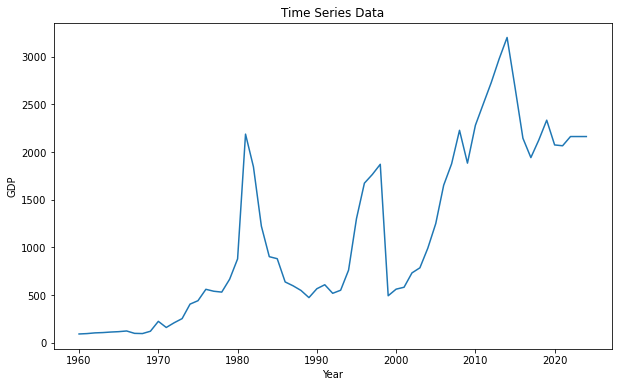

In [116]:
def plot_time_series(y):
    '''Obtaining the time series plot of the target variable.
       y - target variable'''
# Convert year to datetime if necessary
    df['Year'] = pd.to_datetime(df['Year'], format='%Y')

# Plot the time series
    plt.figure(figsize=(10, 6))
    plt.plot(df['Year'], y_gdp)
    plt.title('Time Series Data')
    plt.xlabel('Year')
    plt.ylabel('GDP')
    plt.show()
    
plot_time_series(y_gdp)    

C:\Users\JESSE\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



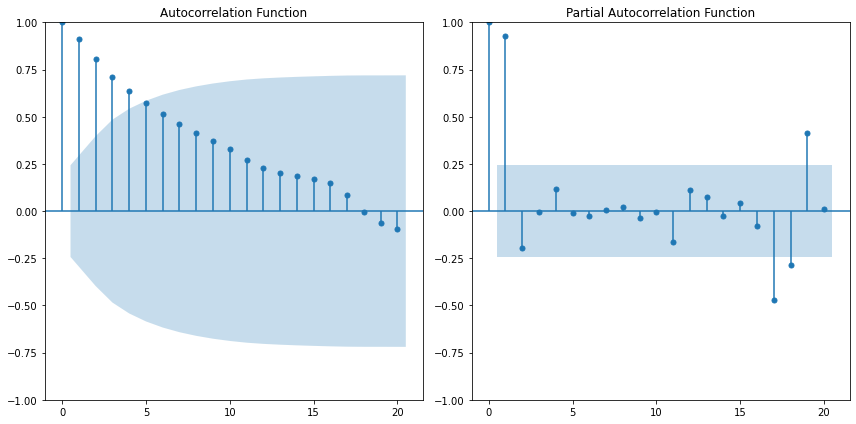

In [117]:
def plot_acf_and_pacf(y):
    '''Getting the Autocorrelation Function and Partial Autocorrelation Function of the time series of the target variable
       y - target variable'''
# Assuming 'y' is your target variable
    plt.figure(figsize=(12, 6))
    max_lags = min(20, len(y) // 2)
# Plot ACF
    plt.subplot(121)
    plot_acf(y, ax=plt.gca(), lags= max_lags)
    plt.title('Autocorrelation Function')

# Plot PACF
    plt.subplot(122)
    plot_pacf(y, ax=plt.gca(), lags= max_lags)
    plt.title('Partial Autocorrelation Function')

    plt.tight_layout()
    plt.show()
plot_acf_and_pacf(y_gdp)

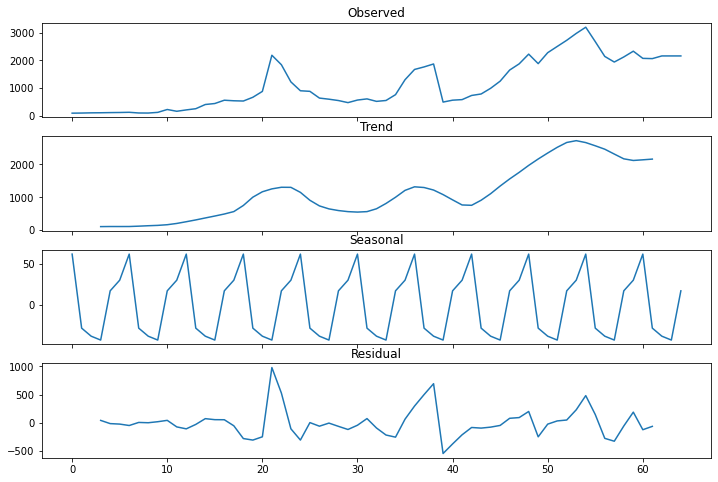

In [118]:

def plot_seasonal_decompose(y,seasonal_period):
    ''' Breaking down the time series to the observed(normal) plot , trend , seasonal and noise plot
        y - target variable
        seasonal_period - years for the completion of a  perceived cycle'''
# Decompose the time series to identify the seasonal component
    result = seasonal_decompose(y, model='additive', period=seasonal_period)  
    # Adjust the period based on the suspected seasonality

# Plot the decomposed components
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 8), sharex=True)
    result.observed.plot(ax=ax1, title='Observed')
    result.trend.plot(ax=ax2, title='Trend')
    result.seasonal.plot(ax=ax3, title='Seasonal')
    result.resid.plot(ax=ax4, title='Residual')
    plt.show()
plot_seasonal_decompose(y_gdp,seasonal_period=6)    
# There is clear seasonality from this plot

In [119]:
# Test to see whether the time series is stationary

def adfuller_test(y):
    '''Test to show whether the time series is stationary or not 
      y - target variable'''
# ADF test
    result = adfuller(y)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    for key, value in result[4].items():
        print(f'Critical Values: {key}: {value}')

# Interpretation
    if result[1] < 0.05:
        print("The series is stationary.")
    else:
        print("The series is not stationary.")
adfuller_test(y_gdp)

ADF Statistic: -1.7239428115961721
p-value: 0.4188205480839048
Critical Values: 1%: -3.5386953618719676
Critical Values: 5%: -2.9086446751210775
Critical Values: 10%: -2.591896782564878
The series is not stationary.


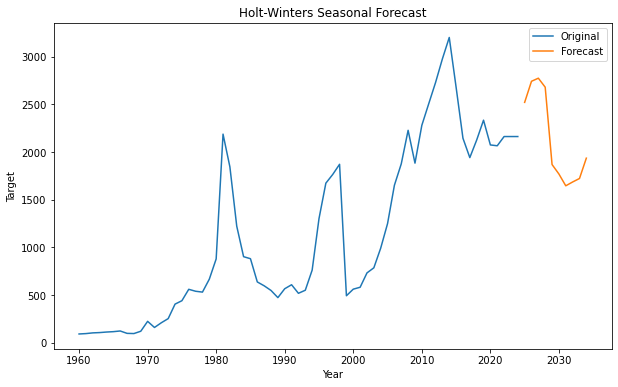

In [120]:
def forecast_without_test(y,seasonal_period,years_in_future):
    '''Shows forecast of the target variable using holt_winters_model(exponential smoothing)
        y - target variable
        seasonal_period - years for the completion of a  perceived cycle
        years_in_future - Number of periods(years) to forecast'''

# Fit Holt-Winters Seasonal model (additive seasonality)
    holt_winters_model = ExponentialSmoothing(y, seasonal='add', seasonal_periods=seasonal_period).fit()

# Forecast
# Number of periods to forecast
    holt_winters_forecast = holt_winters_model.forecast(years_in_future)

# Plot the forecast
    plt.figure(figsize=(10, 6))
    plt.plot(df['Year'], y, label='Original')
    plt.plot(pd.date_range(start=df['Year'].iloc[-1], periods=years_in_future, freq='A'), holt_winters_forecast, label='Forecast')
    plt.title('Holt-Winters Seasonal Forecast')
    plt.xlabel('Year')
    plt.ylabel('Target')
    plt.legend()
    plt.show()
forecast_without_test(y_gdp,30,10)

- The holt winter model was used due to trend in the time series and perceived seasonality

In [121]:

def forecasting(y,seasonal_period,years_in_future):
    '''y - target variable
        seasonal_period - years for the completion of a  perceived cycle
        years_in_future - Number of periods(years) to forecast'''

    # Split the data into training and testing sets
    train_size = int(len(y) * 0.67)
    train, test = y[:train_size], y[train_size:]

    # Fit Holt-Winters Seasonal model (additive seasonality) on the training set
    holt_winters_model = ExponentialSmoothing(train, seasonal='add', seasonal_periods=seasonal_period).fit()

    # Forecast for the test set period
    forecast = holt_winters_model.forecast(len(test))

    # Forecast for the next 10 years beyond the test set period
    forecast_future = holt_winters_model.forecast(len(test) + years_in_future)[-5:]

    # Evaluate the model
    mae = mean_absolute_error(test, forecast)
    mse = mean_squared_error(test, forecast)
    rmse = np.sqrt(mse)

    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")

    # Create a DataFrame for the forecast
    forecast_years = df['Year'][train_size:]
    forecast_df = pd.DataFrame({'year': forecast_years, 'forecast': forecast})

    # Create a DataFrame for the future forecast
    future_years = pd.date_range(start=df['Year'].iloc[-1] + pd.DateOffset(years=1), periods=5, freq='A')
    forecast_df_future = pd.DataFrame({'year': future_years, 'forecast': forecast_future})

    # Plot with Plotly
    fig = go.Figure()

    # Original training data
    fig.add_trace(go.Scatter(x=df['Year'][:train_size], y=train, mode='lines', name='Train'))

    # Original test data
    fig.add_trace(go.Scatter(x=df['Year'][train_size:], y=test, mode='lines', name='Test'))

    # Forecast data
    fig.add_trace(go.Scatter(x=forecast_df['year'], y=forecast_df['forecast'], mode='lines', name='Forecast on Test data'))

    # Future forecast
    fig.add_trace(go.Scatter(x=forecast_df_future['year'], y=forecast_df_future['forecast'], mode='lines', name='Forecast (Future)'))

    # Add a vertical line at 2024
    fig.add_vline(x='2024-01-01', line_width=2, line_dash="dash", line_color="green")

    fig.update_layout(
        title='Holt-Winters Seasonal Forecast',
        xaxis_title='Year',
        yaxis_title='Target',
        showlegend=True
    )

    fig.show()
forecasting(y_gdp,15,10)

Mean Absolute Error (MAE): 1197.3554535205549
Mean Squared Error (MSE): 1687700.716287422
Root Mean Squared Error (RMSE): 1299.115359114587


- The Holt-Winters Seasonal Forecast doesnt fit well with the data

In [122]:
# Feature Engineering 
from sklearn.preprocessing import MinMaxScaler

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['GDP per capita (current US$)']])

# Convert the time series to supervised learning
def create_dataset(dataset, look_back=1):
    X, y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(y)

# Split the data into train and test sets
train_size = int(len(scaled_data) * 0.67)
test_size = len(scaled_data) - train_size
train, test = scaled_data[0:train_size, :], scaled_data[train_size:len(scaled_data), :]

look_back = 1
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))


In [123]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Create and fit the LSTM network
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(1, look_back)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=2)
# save the model


C:\Users\JESSE\Anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/100
41/41 - 6s - 152ms/step - loss: 0.0416
Epoch 2/100
41/41 - 0s - 6ms/step - loss: 0.0249
Epoch 3/100
41/41 - 0s - 7ms/step - loss: 0.0221
Epoch 4/100
41/41 - 0s - 6ms/step - loss: 0.0193
Epoch 5/100
41/41 - 0s - 6ms/step - loss: 0.0169
Epoch 6/100
41/41 - 0s - 7ms/step - loss: 0.0152
Epoch 7/100
41/41 - 0s - 6ms/step - loss: 0.0134
Epoch 8/100
41/41 - 0s - 6ms/step - loss: 0.0134
Epoch 9/100
41/41 - 0s - 6ms/step - loss: 0.0125
Epoch 10/100
41/41 - 0s - 6ms/step - loss: 0.0133
Epoch 11/100
41/41 - 0s - 6ms/step - loss: 0.0124
Epoch 12/100
41/41 - 0s - 6ms/step - loss: 0.0125
Epoch 13/100
41/41 - 0s - 6ms/step - loss: 0.0131
Epoch 14/100
41/41 - 0s - 6ms/step - loss: 0.0124
Epoch 15/100
41/41 - 0s - 6ms/step - loss: 0.0129
Epoch 16/100
41/41 - 0s - 6ms/step - loss: 0.0119
Epoch 17/100
41/41 - 0s - 6ms/step - loss: 0.0123
Epoch 18/100
41/41 - 0s - 6ms/step - loss: 0.0127
Epoch 19/100
41/41 - 0s - 6ms/step - loss: 0.0120
Epoch 20/100
41/41 - 0s - 6ms/step - loss: 0.0117
Epoch 2

In [124]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Invert predictions
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

# Calculate mean squared error
train_score = np.sqrt(mean_squared_error(y_train[0], train_predict[:,0]))
print(f'Train Score: {train_score:.2f} RMSE')
test_score = np.sqrt(mean_squared_error(y_test[0], test_predict[:,0]))
print(f'Test Score: {test_score:.2f} RMSE')

# Calculate mean absolute error
train_mae = mean_absolute_error(y_train[0], train_predict[:,0])
print(f'Train MAE: {train_mae:.2f}')
test_mae = mean_absolute_error(y_test[0], test_predict[:,0])
print(f'Test MAE: {test_mae:.2f}')


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 780ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Train Score: 311.49 RMSE
Test Score: 705.49 RMSE
Train MAE: 168.56
Test MAE: 636.79


In [125]:
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.io as pio

# Shift train predictions for plotting
train_predict_plot = np.empty_like(scaled_data)
train_predict_plot[:, :] = np.nan
train_predict_plot[look_back:len(train_predict) + look_back, :] = train_predict

# Shift test predictions for plotting
test_predict_plot = np.empty_like(scaled_data)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (look_back * 2) + 1:len(scaled_data) - 1, :] = test_predict

# Invert the full dataset for plotting
scaled_data = scaler.inverse_transform(scaled_data)

# Create plotly plot
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=df['Year'], y=scaled_data.flatten(), mode='lines', name='Observed'))
fig.add_trace(go.Scatter(x=df['Year'], y=train_predict_plot.flatten(), mode='lines', name='Train Predict'))
fig.add_trace(go.Scatter(x=df['Year'], y=test_predict_plot.flatten(), mode='lines', name='Test Predict'))

# Add title and labels
fig.update_layout(
    title='LSTM Model Prediction without Forecasting',
    xaxis_title='Year',
    yaxis_title='GDP',
    legend=dict(x=0, y=1)
)

# Show the plot
pio.show(fig)


In [126]:
# Number of years to predict
future_years = 10

# Generate future time steps
last_date = pd.to_datetime(df['Year'].iloc[-1])
future_dates = pd.date_range(start=last_date, periods=future_years + 1, freq='Y')[1:]

# Predict future values
future_predictions = []

# Start with the last `look_back` data points
last_sequence = scaled_data[-look_back:]

for i in range(future_years):
    # Reshape for prediction
    last_sequence_reshaped = np.reshape(last_sequence, (1, 1, look_back))
    next_value = model.predict(last_sequence_reshaped)
    
    # Append prediction
    future_predictions.append(next_value[0, 0])
    
    # Update the sequence with the new prediction
    last_sequence = np.append(last_sequence[1:], next_value)

# Inverse transform predictions
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Plotting
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=df['Year'], y=df['GDP per capita (current US$)'], mode='lines', name='Observed'))
fig.add_trace(go.Scatter(x=df['Year'], y=train_predict_plot.flatten(), mode='lines', name='Train Predict'))
fig.add_trace(go.Scatter(x=df['Year'], y=test_predict_plot.flatten(), mode='lines', name='Test Predict'))
fig.add_trace(go.Scatter(x=future_dates, y=future_predictions.flatten(), mode='lines', name='Future Forecast'))
# Add a vertical line at 2024
fig.add_vline(x='2024-01-01', line_width=2, line_dash="dash", line_color="green")
# Add title and labels
fig.update_layout(
    title='LSTM Model Prediction with Forecasting',
    xaxis_title='Year',
    yaxis_title='GDP',
    legend=dict(x=0, y=1)
)
# Calculate mean absolute error
train_mae = mean_absolute_error(y_train[0], train_predict[:,0])
print(f'Train MAE: {train_mae:.2f}')
test_mae = mean_absolute_error(y_test[0], test_predict[:,0])
print(f'Test MAE: {test_mae:.2f}')
# Show the plot
pio.show(fig)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Train MAE: 168.56
Test MAE: 636.79


In [127]:
# Save the model to a file using Keras' built-in function
model.save('lstm_gdp_per_capita_model.keras')

- ## Key Takeaways
-----------------------
    - The LSTM performs slightly better than the holt winters model
    - The same test size was used so as to make the 2 models comparable 
    - The best rmse and mae for the holt-winter's model was achieved when using 15 as the seasonal period but it was still significantly higher than the metrics gotten from the LSTM

In [128]:
!pip install -q dagshub
from dagshub.notebook import save_notebook

# Define the path to your notebook and the desired upload path in the repository
upload_path = "Time_series/Forecasting_by_Jesse_GDP_per_capita_.ipynb"  
# Save the notebook to the specified folder in the "Model" branch of the repository
save_notebook(repo="Omdena/KadunaNigeriaChapter_NigeriaEconomy", path=upload_path, branch="Model")


Saving only the execution history for the notebook in Jupyter environments

Uploading files (1) to "Omdena/KadunaNigeriaChapter_NigeriaEconomy"...

Upload finished successfully!

NotADirectoryError: [WinError 267] The directory name is invalid: 'C:\\Users\\JESSE\\AppData\\Local\\Temp\\tmpl2ouasmv\\Forecasting_by_Jesse_GDP_per_capita_.ipynb'